## Introduction and Executive Summary

In this file, we implemented "Event Study" to examine whether the technical indicators such as "golden-cross", "death-cross" of Simple Moving Average (SMA) and "overbought", "oversold" signals of RSI (Relative Strength Index) really work or not as trading strategy. 

"Event Study" is often used in econometrics and finance area. Event study enable us to check the price movement after the event day (t+0).  In this case, we examine the price movement between t-30 and t+30, before 30 days and after 30 days from when the golden-cross or death-cross happened. About the detail of Event Study Analysis, please refer the chapter 4 of "The econometrics of financial market" shown at the bottom.

Of course, we do not assure the future return from past success and the investment/trading should be done by self-responsibility. Also, we cannot officially recommend buy or sell recommendation due to compliance matter. However, as results of Event Study and two-sided t-test, we could formulate the prescriptive solutions about when to buy/sell cryptocurrencies, utilizing SMA and RSI technical indicators. 

References:

John Y. Campbell, Andrew W. Lo, A. Craig MacKinlay. The econometrics of financial market, Prinston University Press, 1997. p149-180 Chapter 4.

https://www.nrc.gov/docs/ML1208/ML12088A329.pdf

https://www.eventstudytools.com/introduction-event-study-methodology

https://www.investopedia.com/terms/e/eventstudy.asp#:~:text=An%20event%20study%20is%20an,react%20to%20a%20given%20event.





## Setup for colab and libraries

In [ ]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/FinalPackage'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/FinalPackage']


In [ ]:
#Install necessary libraries
!pip install pandas

In [ ]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import time
import pandas_datareader.data as web
import math
#handling date
from datetime import datetime
#Statistics
from scipy import stats

In [ ]:
#in the process, there arises some warning. Ignore it.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#For data checking purpuse such as head(), tail(),
#just changed max disaplay row to 100 rows
pd.set_option('display.max_rows', 100)

## Event Study for SMA, Simple Moving Average strategy.

To check whether golen-cross and death-cross of Simple Moving Average (SMA) are really useful or not, we implement "Event Study", which is often used in econometrics and finance area. Event study enable us to check the price movement after the event day (t+0). 

In this case, we examine the price movement between t-30 and t+30, before 30 days and after 30 days from when the golden-cross or death-cross happened.

### Data acquisition

In [ ]:
#We set 4 decimal points as default, following by market custom.
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
main_df = pd.read_csv("./team12_cleandata.csv")
del main_df['Unnamed: 0']
main_df.head()

,day,btc_price,btc_mktcap,btc_volume,eth_price,eth_mktcap,eth_volume,xrp_price,xrp_mktcap,xrp_volume,ltc_price,ltc_mktcap,ltc_volume,btc_price_chg,btc_mktcap_chg,btc_volume_chg,eth_price_chg,eth_mktcap_chg,eth_volume_chg,xrp_price_chg,xrp_mktcap_chg,xrp_volume_chg,ltc_price_chg,ltc_mktcap_chg,ltc_volume_chg,btc_vol20d,eth_vol20d,xrp_vol20d,ltc_vol20d,btc_vol60d,eth_vol60d,xrp_vol60d,ltc_vol60d,btc_SMA10d,eth_SMA10d,xrp_SMA10d,ltc_SMA10d,btc_SMA50d,eth_SMA50d,xrp_SMA50d,...,spx_SMA50d,ndx_SMA50d,gold_SMA50d,us10y_SMA50d,dxy_SMA50d,spx_SMA100d,ndx_SMA100d,gold_SMA100d,us10y_SMA100d,dxy_SMA100d,spx_SMA200d,ndx_SMA200d,gold_SMA200d,us10y_SMA200d,dxy_SMA200d,spx_DiffSMA10d,ndx_DiffSMA10d,gold_DiffSMA10d,us10y_DiffSMA10d,dxy_DiffSMA10d,spx_DiffSMA50d,ndx_DiffSMA50d,gold_DiffSMA50d,us10y_DiffSMA50d,dxy_DiffSMA50d,spx_DiffSMA100d,ndx_DiffSMA100d,gold_DiffSMA100d,us10y_DiffSMA100d,dxy_DiffSMA100d,spx_DiffSMA200d,ndx_DiffSMA200d,gold_DiffSMA200d,us10y_DiffSMA200d,dxy_DiffSMA200d,spx_RSI,ndx_RSI,gold_RSI,us10y_RSI,dxy_RSI
0,2013-04-28,135.3000,1500517590.0000,0.0000,nan,nan,nan,nan,nan,nan,4.2998,73773387.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1554.4250,2797.0750,1545.0000,1.8590,82.5992,1523.0785,2767.9025,1597.4525,1.9042,81.4073,nan,nan,nan,nan,nan,0.0096,0.0108,0.0325,-0.0139,-0.0026,0.0142,0.0119,-0.0476,-0.0855,-0.0014,0.0351,0.0226,-0.0788,-0.1072,0.0132,nan,nan,nan,nan,nan,56.7657,55.7151,45.5074,35.5147,48.3449
1,2013-04-29,141.9600,1575032004.0000,0.0000,nan,nan,nan,nan,nan,nan,4.3594,74936909.0000,0.0000,0.0492,0.0497,nan,nan,nan,nan,nan,nan,nan,0.0139,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1555.8600,2799.2800,1542.7050,1.8558,82.5960,1524.4135,2769.1075,1595.1900,1.9026,81.4303,nan,nan,nan,nan,nan,0.0144,0.0178,0.0243,-0.0122,-0.0060,0.0208,0.0213,-0.0487,-0.0840,-0.0054,0.0419,0.0325,-0.0800,-0.1065,0.0088,nan,nan,nan,nan,nan,60.8551,60.6802,44.5890,35.5147,42.8319
2,2013-04-30,135.3000,1501657493.0000,0.0000,nan,nan,nan,nan,nan,nan,4.1829,72037636.0000,0.0000,-0.0469,-0.0466,nan,nan,nan,nan,nan,nan,nan,-0.0405,-0.0387,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1557.3900,2801.9500,1540.4400,1.8526,82.5844,1525.8060,2770.6700,1593.0850,1.9004,81.4433,nan,nan,nan,nan,nan,0.0138,0.0212,0.0200,-0.0111,-0.0101,0.0229,0.0287,-0.0464,-0.0824,-0.0103,0.0440,0.0403,-0.0779,-0.1055,0.0035,nan,nan,nan,nan,nan,62.4033,64.2059,45.0369,35.5147,37.0423
3,2013-05-01,117.0000,1298951550.0000,0.0000,nan,nan,nan,nan,nan,nan,3.6491,62957992.0000,0.0000,-0.1353,-0.1350,nan,nan,nan,nan,nan,nan,nan,-0.1276,-0.1260,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1558.4500,2804.0800,1538.0500,1.8482,82.5728,1527.0265,2772.2300,1591.1525,1.8977,81.4547,nan,nan,nan,nan,nan,0.0033,0.0129,0.0066,-0.0304,-0.0099,0.0137,0.0232,-0.0542,-0.1018,-0.0113,0.0345,0.0349,-0.0857,-0.1253,0.0023,nan,nan,nan,nan,nan,55.7765,60.8569,41.5966,30.1364,35.9218
4,2013-05-02,103.4300,1148667722.0000,0.0000,nan,nan,nan,nan,nan,nan,3.3888,58565340.0000,0.0000,-0.1160,-0.1157,nan,nan,nan,nan,nan,nan,nan,-0.0713,-0.0698,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1559.5100,2806.1150,1535.8400,1.8434,82.5752,1528.3695,2774.1200,1589.3650,1.8950,81.4718,nan,nan,nan,nan,nan,0.0082,0.0198,0.0122,-0.0264,-0.0024,0.0208,0.0342,-0.0434,-0.0995,-0.0044,0.0416,0.0461,-0.0756,-0.1240,0.0091,nan,nan,nan,nan,nan,60.0052,65.6610,46.1078,30.1364,46.8811


In [ ]:
#Extract only relevant data
sma_btc_df = main_df[['day','btc_price', 'btc_price_chg', 'btc_SMA10d', 'btc_SMA50d', 'btc_SMA100d','btc_SMA200d']]
sma_eth_df = main_df[['day','eth_price', 'eth_price_chg', 'eth_SMA10d', 'eth_SMA50d', 'eth_SMA100d','eth_SMA200d']]
sma_xrp_df = main_df[['day','xrp_price', 'xrp_price_chg', 'xrp_SMA10d', 'xrp_SMA50d', 'xrp_SMA100d','xrp_SMA200d']]
sma_ltc_df = main_df[['day','ltc_price', 'ltc_price_chg', 'ltc_SMA10d', 'ltc_SMA50d', 'ltc_SMA100d','ltc_SMA200d']]

In [ ]:
#change data type of day as datetime.
sma_btc_df['day'] = sma_btc_df['day'].astype('datetime64[ns]')
sma_eth_df['day'] = sma_eth_df['day'].astype('datetime64[ns]')
sma_xrp_df['day'] = sma_xrp_df['day'].astype('datetime64[ns]')
sma_ltc_df['day'] = sma_ltc_df['day'].astype('datetime64[ns]')

In [ ]:
sma_btc_df.head()

,day,btc_price,btc_price_chg,btc_SMA10d,btc_SMA50d,btc_SMA100d,btc_SMA200d
0,2013-04-28,135.3000,nan,nan,nan,nan,nan
1,2013-04-29,141.9600,0.0492,nan,nan,nan,nan
2,2013-04-30,135.3000,-0.0469,nan,nan,nan,nan
3,2013-05-01,117.0000,-0.1353,nan,nan,nan,nan
4,2013-05-02,103.4300,-0.1160,nan,nan,nan,nan


### Extract golden cross and death cross

By GetSignal function, we check the price is above SMA or below SMA.

In [ ]:
def GetSignal(df,sma_column):
    price_name = df.columns[1]
    signal_name = str(sma_column) + '_Signal'
    df[signal_name] = 0.0
    df[signal_name] = np.where(df[price_name] > df[sma_column], 1.0, 0.0)
    return df

In [ ]:
for df in [sma_btc_df, sma_eth_df, sma_xrp_df, sma_ltc_df]:
  for column in df.columns[3:7].to_list():
    GetSignal(df, column)

By GetPosition function, we check the day of golden cross and death cross. +1 is golden cross, -1 is death cross. '_Position' columns returns the day of golden/death crosses.

In [ ]:
def GetPosition(df, sma_column):
    price_name = df.columns[1]
    signal_name = str(sma_column) + '_Signal'
    position_name = str(sma_column) + '_Position'
    df[position_name] = 0.0
    df[position_name] = df[signal_name].diff()
    
    return df

In [ ]:
for df in [sma_btc_df, sma_eth_df, sma_xrp_df, sma_ltc_df]:
  for column in df.columns[3:7].to_list():
    GetPosition(df, column)

In [ ]:
sma_btc_df.head()

,day,btc_price,btc_price_chg,btc_SMA10d,btc_SMA50d,btc_SMA100d,btc_SMA200d,btc_SMA10d_Signal,btc_SMA50d_Signal,btc_SMA100d_Signal,btc_SMA200d_Signal,btc_SMA10d_Position,btc_SMA50d_Position,btc_SMA100d_Position,btc_SMA200d_Position
0,2013-04-28,135.3000,nan,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan
1,2013-04-29,141.9600,0.0492,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2013-04-30,135.3000,-0.0469,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2013-05-01,117.0000,-0.1353,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2013-05-02,103.4300,-0.1160,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Implementing Event Study

In [ ]:
def plotGoldenDeathCrosses(df,xxx_price, xxx_SMAxxd, xxx_SMAxxd_Position):
  #Trading signal visualization
  plt.figure(figsize = (12, 6))
  plt.suptitle("Trading signals", fontsize=20, y=1.03)

  # plot golden cross
  plt.plot(df[xxx_price][df[xxx_SMAxxd_Position] == 1], 
          '^', markersize = 7, color = 'g', label = 'golden-cross')
  # plot death cross
  plt.plot(df[xxx_price][df[xxx_SMAxxd_Position] == -1], 
          '^', markersize = 7, color = 'r', label = 'death-cross')

  # plot close price and simple moving averages 
  plt.plot(df[xxx_price],color = 'k', label= 'btc_price') 
  plt.plot(df[xxx_SMAxxd],color = 'b',label = 'SMA') 

  plt.xlabel('Days since the beginning day of trade', fontsize = 15 )
  plt.ylabel('Coin Price (USD)', fontsize = 15 )
  plt.legend(loc=0)
  plt.show()

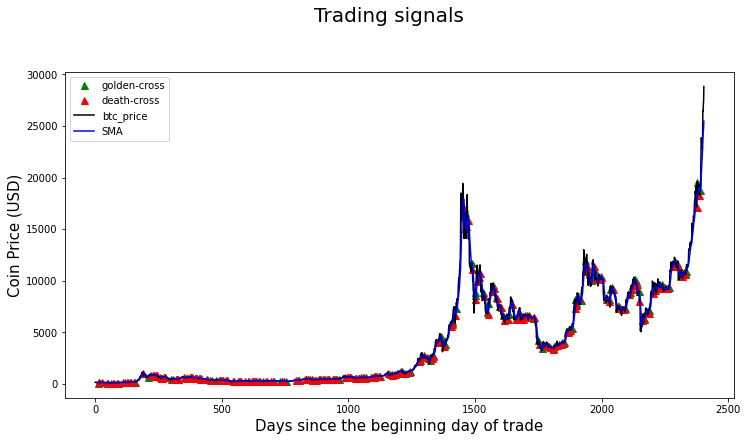

In [ ]:
plotGoldenDeathCrosses(sma_btc_df,'btc_price', 'btc_SMA10d', 'btc_SMA10d_Position')

In [ ]:
#listing the day indexes of when golden/death cross happened.
btc_10dSMA_gcross = sma_btc_df[sma_btc_df['btc_SMA10d_Position'] == 1].index.to_list()
btc_10dSMA_dcross = sma_btc_df[sma_btc_df['btc_SMA10d_Position'] == -1].index.to_list()

In [ ]:
btc_10dSMA_gcross[:5]

[10, 16, 45, 64, 75]

In [ ]:
#Function to get one event window prices.
def obtainPriceWindow(crossIndex, price_df, beforespan, afterspan):
  day_start = np.maximum(0, crossIndex - beforespan)
  day_end = np.minimum(crossIndex + afterspan + 1, len(price_df))

  if crossIndex - beforespan < 0:
    price_window = [np.nan] * abs(crossIndex - beforespan) + price_df.iloc[day_start:day_end, 1].to_list()
  elif crossIndex + afterspan > len(price_df):
    price_window = price_df.iloc[day_start:day_end, 1].to_list() + [np.nan] * abs(crossIndex + afterspan - len(price_df))
  else:
    price_window = price_df.iloc[day_start:day_end, 1].to_list()
  
  return price_window

In [ ]:
obtainPriceWindow(10, sma_btc_df, 30, 30)[-10:]

[121.16,
 121.16,
 121.309,
 121.714,
 119.0,
 108.401,
 99.7497,
 105.99,
 108.9,
 108.4]

In [ ]:
#Obtaining all price windows under one golden/death cross
def obtainAllPriceWindows(currency,event_list, sma_xxx_df, beforespan, afterspan):

  #price column name such as btc_price
  price = str(currency) + '_price'

  price_window_list = []
  #Based on event day of t+0, obtain t-30 - t+30 prices. 
  for crossIndex in event_list:
    price_window_temp = obtainPriceWindow(crossIndex, sma_xxx_df, beforespan, afterspan)
    price_window_list.append(price_window_temp)

  #If there is nan data, just filling in ffill and bfill.  
  price_window_df = pd.DataFrame(price_window_list).T
  price_window_df = price_window_df.fillna(method='ffill')
  price_window_df = price_window_df.fillna(method='bfill')

  #Obtain prices of t+0
  t0_prices = sma_xxx_df[sma_xxx_df.index.isin(event_list)][price]
  t0_prices_df = pd.DataFrame(t0_prices).T

  #Dividing t-30 - t+30 prices by t+0 price, such that t+0 = 0.
  price_window_alldata_df = price_window_df.div(t0_prices_df.values, axis=1) - 1

  #Implement ttest
  ttest_results = price_window_alldata_df.apply(lambda x: stats.ttest_1samp(x, 0), axis=1)
  ttest_results_df = pd.DataFrame.from_records(ttest_results,columns=['ttestStat','pvalue'])

  #Only taking 95% confidence interval and mean of t-30 - t+30  
  event_study_df = pd.DataFrame([price_window_alldata_df.mean(axis=1),
                            price_window_alldata_df.quantile(0.975, axis=1),
                            price_window_alldata_df.quantile(0.025, axis=1)]).T
  event_study_df.columns = ['mean','Upper2.5tile', 'lower2.5tile']

  #change index range
  price_window_alldata_df.index = np.arange(-beforespan,0).tolist() + np.arange(0,afterspan+1).tolist()
  ttest_results_df.index = np.arange(-beforespan,0).tolist() + np.arange(0,afterspan+1).tolist()
  event_study_df.index = np.arange(-beforespan,0).tolist() + np.arange(0,afterspan+1).tolist()

  return price_window_alldata_df, ttest_results_df, event_study_df

In [ ]:
gcross_alldata_df, gcross_ttest_df, gcross_event_df = obtainAllPriceWindows('btc',btc_10dSMA_gcross, sma_btc_df, 30, 30)

In [ ]:
gcross_alldata_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190
-30,0.1973,0.1714,0.0714,0.4194,0.1266,-0.2631,-0.1891,-0.0898,0.0329,-0.3238,-0.1546,-0.0920,-0.2381,-0.1314,-0.0927,0.3454,0.4447,0.5225,0.3022,0.0675,0.3574,-0.0041,0.0031,0.0424,-0.0091,-0.2535,-0.1233,0.0282,-0.0895,0.0074,0.0876,0.1111,0.2081,0.2122,0.1162,0.3659,0.1283,0.0054,-0.0332,-0.1057,...,-0.2685,-0.2776,-0.2355,-0.1815,0.2915,0.0014,-0.0787,0.1560,0.2982,0.2555,0.0846,-0.1181,0.2198,0.2414,0.2056,0.0279,-0.1739,-0.2500,-0.1314,-0.1263,0.0521,0.6566,0.5103,-0.2715,-0.2438,-0.2091,-0.2266,0.0031,0.0884,0.0150,-0.1855,-0.2298,-0.1517,0.1245,0.0869,0.0474,0.0823,-0.0635,-0.3340,-0.2121
-29,0.1973,0.1714,0.0840,0.3878,0.1408,-0.2737,-0.2277,-0.0746,-0.0072,-0.3324,0.0095,-0.2042,-0.2434,-0.0907,-0.0776,0.3952,0.3787,0.3264,0.2617,0.0955,0.3640,0.0177,0.0295,0.0257,-0.1877,-0.2540,-0.0482,0.0302,-0.0453,0.0078,0.0982,0.0976,0.2161,0.2101,0.1854,0.3400,0.1014,0.0124,-0.0384,-0.1392,...,-0.2427,-0.3060,-0.2853,-0.1666,0.1109,-0.1246,-0.0731,0.0891,0.2925,0.2510,0.0894,-0.1079,0.2575,0.2283,0.1893,0.0074,-0.1816,-0.2740,-0.1296,-0.1323,0.0359,0.6035,0.4595,-0.2614,-0.1322,-0.2142,-0.2103,0.0084,0.0185,0.0084,-0.2024,-0.2271,-0.0631,0.1191,0.0842,0.0579,0.1029,-0.0653,-0.3036,-0.1760
-28,0.1973,0.1714,0.1553,0.2642,0.1727,-0.2679,-0.2146,-0.0743,-0.0364,-0.3358,0.0933,-0.3564,-0.2268,-0.0971,-0.0719,0.3958,0.4558,0.3944,0.1305,0.1083,0.3943,0.0218,0.0230,0.0023,-0.0545,-0.1876,-0.0311,0.0207,-0.0634,0.0739,0.1053,0.0751,0.2035,0.1746,0.1887,0.3410,0.0551,0.0045,-0.0496,-0.1392,...,-0.1089,-0.2857,-0.3281,-0.1356,0.1898,-0.1137,-0.0252,0.1104,0.2921,0.2430,0.0523,-0.1097,0.2228,0.2516,0.1679,-0.0058,-0.1887,-0.2336,-0.1394,-0.1228,0.0331,0.6116,0.3746,-0.2354,-0.1356,-0.2590,-0.1951,-0.0157,0.0324,0.0016,-0.2026,-0.2242,-0.0680,0.1364,0.0945,0.0427,0.0587,-0.0577,-0.3226,-0.1846
-27,0.1973,0.1714,0.1309,0.1633,0.1340,-0.1847,-0.2118,-0.0468,-0.0697,-0.3258,0.1431,-0.2201,-0.2165,-0.0821,-0.0083,0.3886,0.5212,0.3950,0.0533,0.0408,0.3964,0.0487,0.0066,-0.1784,-0.0659,-0.1786,-0.0481,0.0289,-0.0488,0.0843,0.0919,0.0817,0.2023,0.1752,0.1892,0.3145,-0.0370,-0.0570,-0.0547,-0.1285,...,-0.1463,-0.2699,-0.3169,-0.1560,0.0820,-0.0238,0.0037,0.0942,0.2788,0.2376,-0.0558,-0.1282,0.2449,0.2411,0.1696,-0.0089,-0.1882,-0.2338,-0.1211,-0.1288,0.0299,0.5759,0.3714,-0.2872,-0.1759,-0.2553,-0.1856,-0.0639,0.0464,-0.0026,-0.1971,-0.2275,-0.0519,0.0919,0.0566,0.0594,-0.0545,-0.0486,-0.3145,-0.1876
-26,0.1973,0.1714,0.1504,0.2360,0.1419,-0.1082,-0.2011,-0.0669,-0.0344,-0.3256,0.1859,-0.2012,-0.1393,-0.0764,0.1046,0.3596,0.3253,0.3963,0.0808,0.0355,0.3759,0.0421,-0.0163,-0.0436,0.0301,-0.1217,-0.0446,-0.0013,-0.0253,0.0913,0.0695,0.0620,0.2005,0.1562,0.1714,0.3163,-0.0263,-0.0620,-0.0458,-0.1030,...,-0.0416,-0.3175,-0.3161,-0.1381,0.0572,-0.0112,0.0454,0.0483,0.2718,0.2491,-0.0836,-0.1321,0.2138,0.2464,0.1276,-0.0192,-0.1770,-0.1936,-0.1424,-0.1539,0.0156,0.6424,0.3357,-0.2366,-0.0919,-0.2613,-0.1873,-0.0525,0.0343,-0.0092,-0.2020,-0.2089,-0.0500,0.1092,0.0672,0.0797,-0.0563,-0.0701,-0.2973,-0.1659


Below is the illustration of all events of "golden-cross" historically, between t-30 days and t+ 30 days (t+0 is event day).

Text(0, 0.5, 'cumulative return % from t+0=event day')

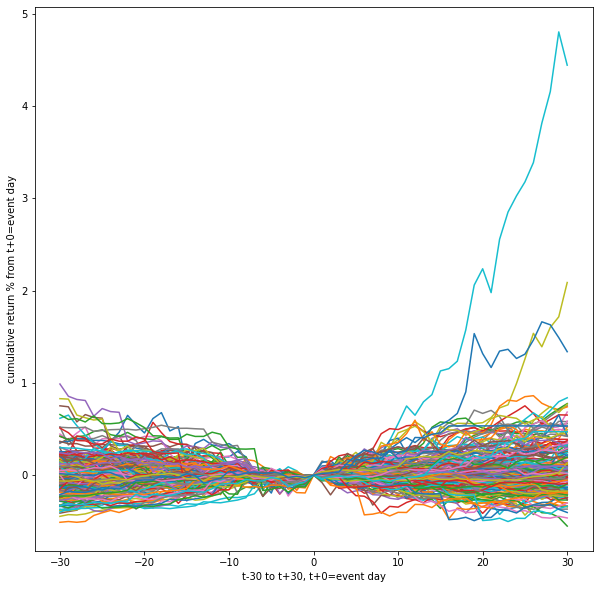

In [ ]:
gcross_alldata_df.plot(figsize=(10,10),legend=False)
plt.xlabel("t-30 to t+30, t+0=event day")
plt.ylabel("cumulative return % from t+0=event day")

In [ ]:
gcross_ttest_df.tail()

,ttestStat,pvalue
26,3.3615,0.0009
27,3.2425,0.0014
28,3.2544,0.0013
29,3.1426,0.0019
30,3.3790,0.0009


In [ ]:
gcross_event_df.head()

,mean,Upper2.5tile,lower2.5tile
-30,0.0033,0.5458,-0.3824
-29,0.0013,0.5360,-0.3722
-28,0.0031,0.5188,-0.3640
-27,0.0011,0.5194,-0.3293
-26,0.0037,0.4730,-0.3305


Showing all 191 cases of golden-cross by line looks a bit busy in looking. So, below function can offer the summary of 95% range of cumulative returns in t-30 - t+30. Also, we can see one-sided t-test statistics and p-value. Please note that the null hypothesis of this one-sided t-test is "mean cumulative return at t+x is not different from zero %", and the alternative hypothesis is that "mean cumulative return at t+x is different from zero % (significantly higher or lower than zero %). 

In [ ]:
#showing summary graphs
def eventSummaryGraph(event_df, ttest_df, beforespan, afterspan):

  window_size = len(gcross_event_df) 

  fig, axes = plt.subplots(3, 1, figsize=(10, 8))

  g0 = sns.lineplot(data=event_df, ax=axes[0])
  g0.set_ylabel("cumulative return % from t+0")
  g1 = sns.lineplot(data=ttest_df['ttestStat'], ax=axes[1])
  g2 = sns.lineplot(data=ttest_df['pvalue'], ax=axes[2])
  g2.hlines(0.05, -beforespan, afterspan, colors='r')
  g2.set(ylim=(0, 0.5))
  g2.set_xlabel("t-30 to t+30, t+0=event day")

  plt.tight_layout()
  plt.show()

It looks that we can decline null hypothesis of "cumulative return in t+1 - t+30 is zero", as we can see very low p-value after x axis = 31.

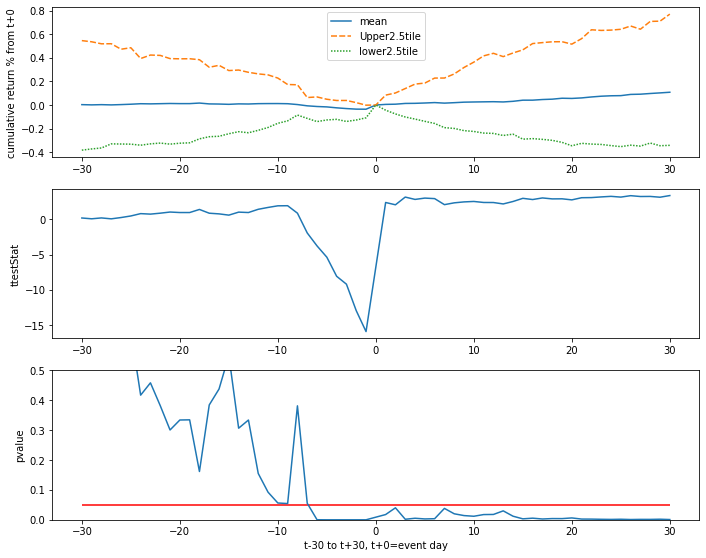

In [ ]:
 eventSummaryGraph(gcross_event_df, gcross_ttest_df, 30, 30)

But wait for a moment. What about the results of death cross?

In [ ]:
dcross_alldata_df, dcross_ttest_df, dcross_event_df = obtainAllPriceWindows('btc', btc_10dSMA_dcross, sma_btc_df, 30, 30)

Unfortunately, even after the death cross, the price of bitcoin can go up, seeing the day after t+20 days in x-axis. This means that we should compare the difference between the price movement after golden cross and the price movement after death cross.

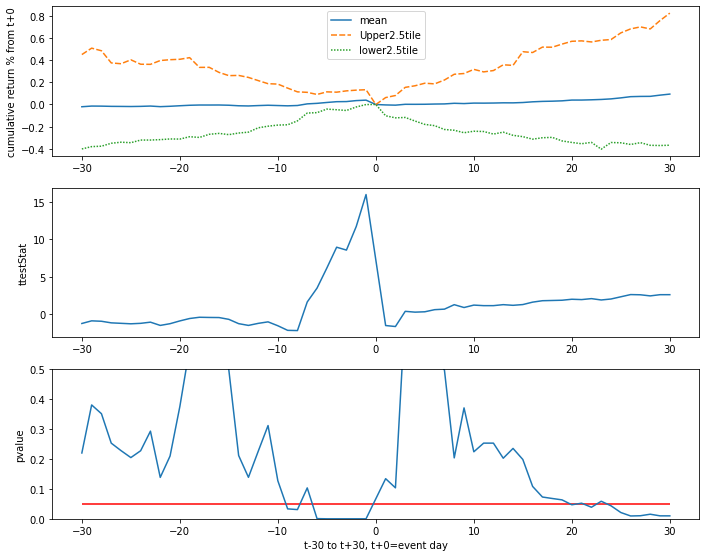

In [ ]:
 eventSummaryGraph(dcross_event_df, dcross_ttest_df, 30, 30)

So, we can do a two-sided test for the null hypothesis that the price movements after both golden-cross and death-cross have identical average (expected) values.

In [ ]:
#Implementing two-sided test
def twoSidedTestForOneSMA(currency, sma_xxx_df,xxx_SMAxxxd_Position, beforespan, afterspan):
  #listing the day indexes of when golden/death cross happened.
  goldcross = sma_xxx_df[sma_xxx_df[xxx_SMAxxxd_Position] == 1].index.to_list()
  deathcross = sma_xxx_df[sma_xxx_df[xxx_SMAxxxd_Position] == -1].index.to_list()

  gcross_alldata_df, gcross_ttest_df, gcross_event_df = obtainAllPriceWindows(currency, goldcross, sma_xxx_df, beforespan, afterspan)
  dcross_alldata_df, dcross_ttest_df, dcross_event_df = obtainAllPriceWindows(currency, deathcross, sma_xxx_df, beforespan, afterspan)

  twosidedtest_list = []
  #Based on event day of t+0, obtain t-30 - t+30 prices. 
  for t in range(len(gcross_alldata_df)):
    twosidedtest_temp = stats.ttest_ind(gcross_alldata_df.iloc[t,:], dcross_alldata_df.iloc[t,:])
    twosidedtest_list.append(twosidedtest_temp)
    twosidetest_results_df = pd.DataFrame.from_records(twosidedtest_list,columns=['twoSideTestStat','pvalue'])

  twosidetest_results_df.index = np.arange(-beforespan,0).tolist() + np.arange(0,afterspan+1).tolist()

  return gcross_event_df, dcross_event_df, twosidetest_results_df

In [ ]:
btc_SMA10d_gcross, btc_SMA10d_dcross, btc_SMA10d_twoside_df = twoSidedTestForOneSMA('btc', sma_btc_df,'btc_SMA10d_Position', 30, 30)

In [ ]:
btc_SMA10d_twoside_df.iloc[30:40,:]

,twoSideTestStat,pvalue
0,nan,nan
1,2.7030,0.0072
2,2.6076,0.0095
3,1.8812,0.0607
4,1.6887,0.0921
5,1.7536,0.0803
6,1.7104,0.0880
7,0.9932,0.3212
8,0.7455,0.4564
9,1.1746,0.2409


In [ ]:
#showing summary graphs
def twoSideSummaryGraph(xxx_SMAxxxd_gcross, xxx_SMAxxxd_dcross, xxx_SMAxxxd_twoside_df, beforespan, afterspan):
  fig, axes = plt.subplots(4, 1, figsize=(10, 8))

  g0 = sns.lineplot(data=xxx_SMAxxxd_gcross, ax=axes[0])
  g0.set_title("Golden cross event")
  g0.set_ylabel("cum return % from t+0")
  g1 = sns.lineplot(data=xxx_SMAxxxd_dcross, ax=axes[1])
  g1.set_title("Death cross event")
  g1.set_ylabel("cum return % from t+0")
  g2 = sns.lineplot(data=xxx_SMAxxxd_twoside_df['twoSideTestStat'], ax=axes[2])
  g2.set_title("two-sided ttest statistic value")
  g3 = sns.lineplot(data=xxx_SMAxxxd_twoside_df['pvalue'], ax=axes[3])
  g3.hlines(0.05, -beforespan, afterspan, colors='r')
  g3.set(ylim=(0, 0.5))
  g3.set_title("p-value")
  g3.set_xlabel("t-30 to t+30, t+0=event day")

  plt.tight_layout()
  plt.show()

From seeing below results of two-sided test, t+1 and t+2, are statistically different performance between golden-cross and death cross. For t+3 and later, we cannot decline null hypothesis that the mean returns between golden-cross and death-cross are same. In t+2, while mean cumulative return after the golden-cross was +0.70%, that after the death-cross was -0.60%. It implies that we can buy bitcoin at golden-cross while we can sell bitcoin at death-cross, such that we can make the spread of profit by +1.30% in average. 

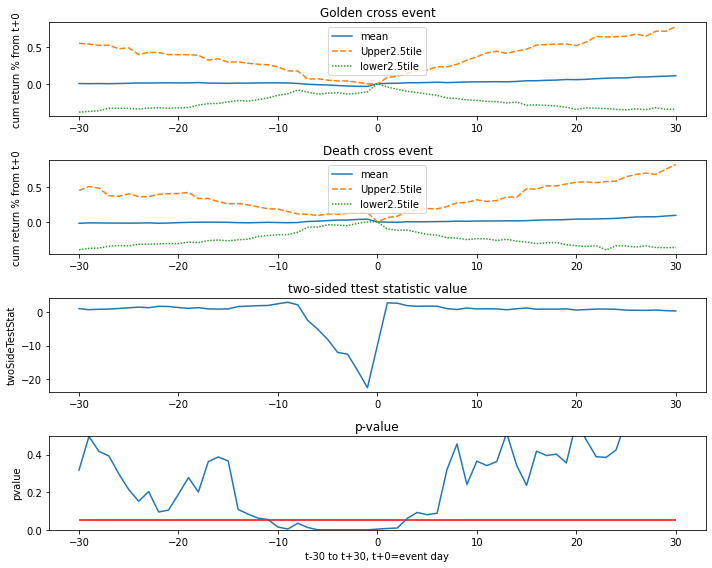

In [ ]:
twoSideSummaryGraph(btc_SMA10d_gcross, btc_SMA10d_dcross, btc_SMA10d_twoside_df, 30, 30)

In [ ]:
btc_SMA10d_gcross.iloc[30:33,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0053,0.0839,-0.0437
2,0.0071,0.1022,-0.0755


In [ ]:
btc_SMA10d_dcross.iloc[30:33,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,-0.0039,0.0625,-0.1019
2,-0.0060,0.0812,-0.1205


In [ ]:
btc_SMA10d_twoside_df.iloc[30:33,:]

,twoSideTestStat,pvalue
0,nan,nan
1,2.7030,0.0072
2,2.6076,0.0095


### Application of two side ttest to btc, eth, xrp, ltc.

In [ ]:
def twoSideSummaryForOneCrypt(currency, sma_xxx_df, beforespan, afterspan):
  SMA10d_Position = str(currency) + '_SMA10d_Position'
  SMA50d_Position = str(currency) + '_SMA50d_Position'
  SMA100d_Position = str(currency) + '_SMA100d_Position'
  SMA200d_Position = str(currency) + '_SMA200d_Position'

  position_list = [SMA10d_Position, SMA50d_Position, SMA100d_Position, SMA200d_Position]

  for position in position_list:
    
    print('Graph: ' + str(position) + ', golden/death cross comparison')
    SMA10d_gcross, SMA10d_dcross, SMA10d_twoside_df = twoSidedTestForOneSMA(currency, sma_xxx_df,position, beforespan, afterspan)
    twoSideSummaryGraph(SMA10d_gcross, SMA10d_dcross, SMA10d_twoside_df, beforespan, afterspan)

### Bitcoin

From seeing below results of two-sided test, t+1 and t+2, are statistically different performance between golden-cross and death cross. For t+3 and later, we cannot decline null hypothesis that the mean returns between golden-cross and death-cross are same. In t+2, while mean cumulative return after the golden-cross was +0.70%, that after the death-cross was -0.60%. It implies that we can buy bitcoin at golden-cross while we can sell bitcoin at death-cross, such that we can make the spread of profit by +1.30% in average. 

However, other than above results, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and death-cross. 

Graph: btc_SMA10d_Position, golden/death cross comparison


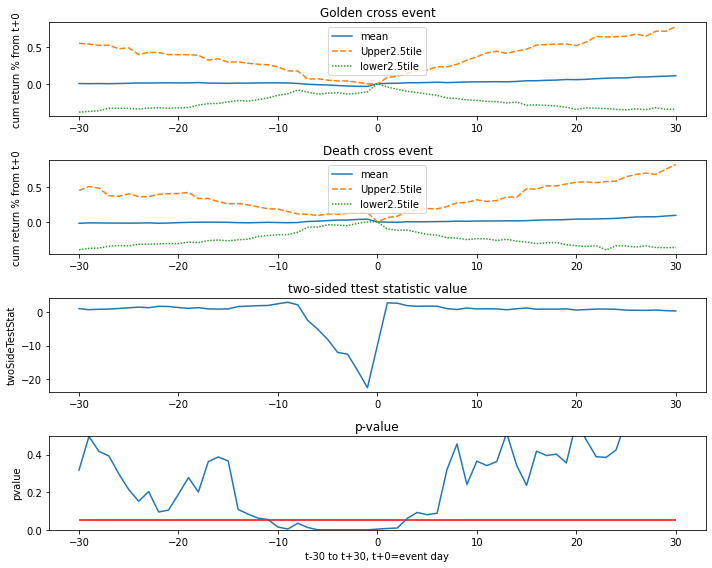

Graph: btc_SMA50d_Position, golden/death cross comparison


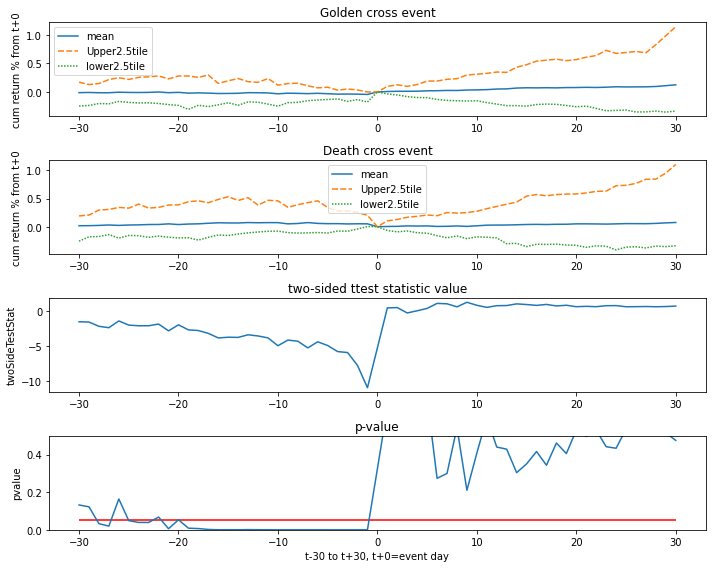

Graph: btc_SMA100d_Position, golden/death cross comparison


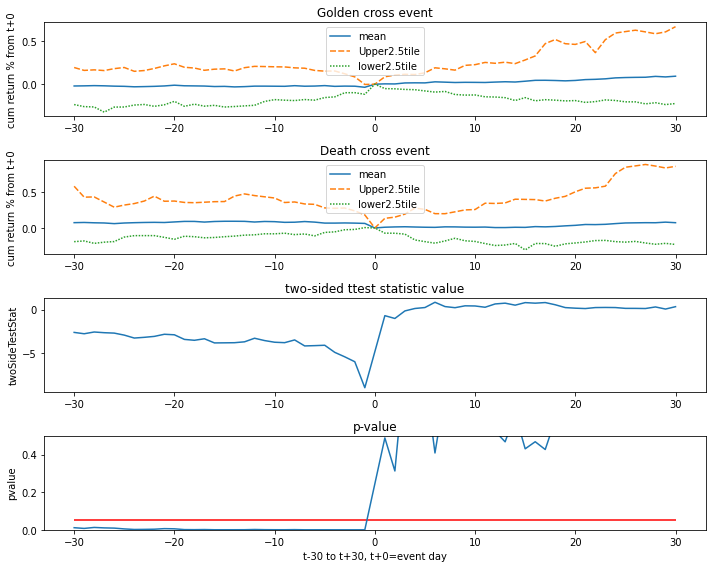

Graph: btc_SMA200d_Position, golden/death cross comparison


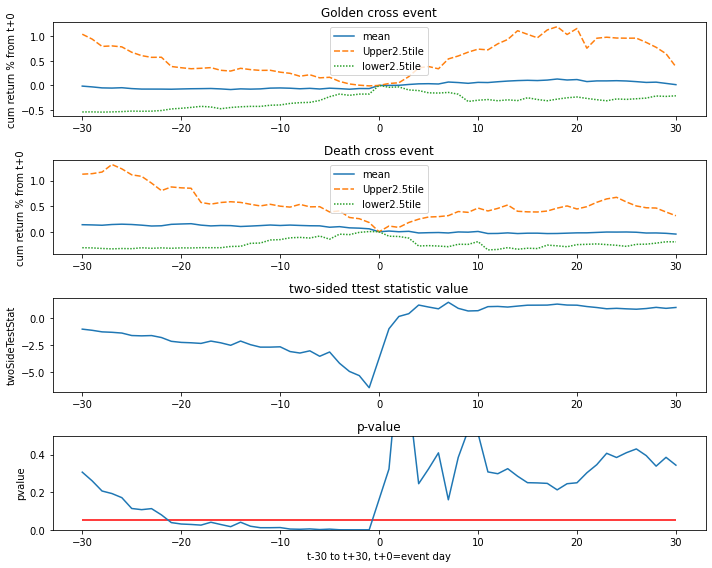

In [ ]:
twoSideSummaryForOneCrypt('btc', sma_btc_df, 30, 30)

### Eth

Unfortunately, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and after death-cross.



Graph: eth_SMA10d_Position, golden/death cross comparison


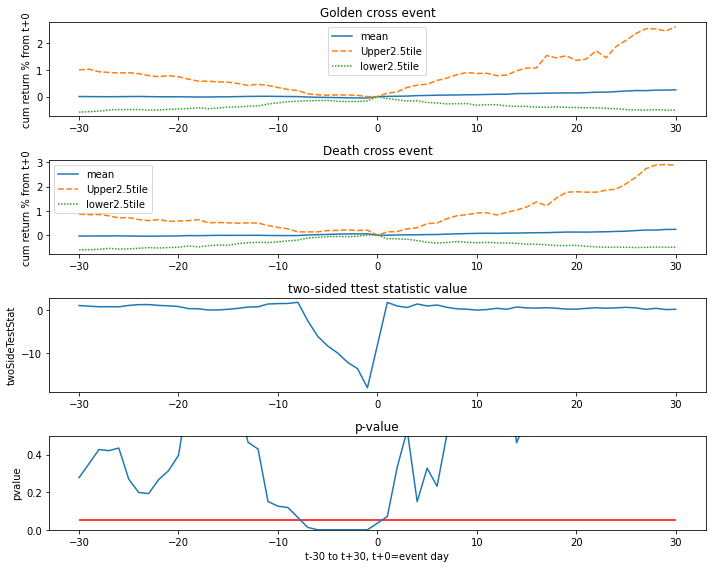

Graph: eth_SMA50d_Position, golden/death cross comparison


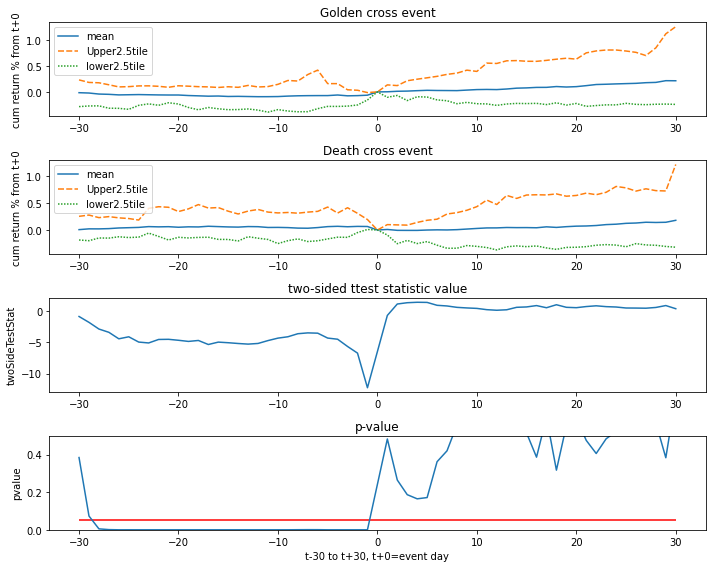

Graph: eth_SMA100d_Position, golden/death cross comparison


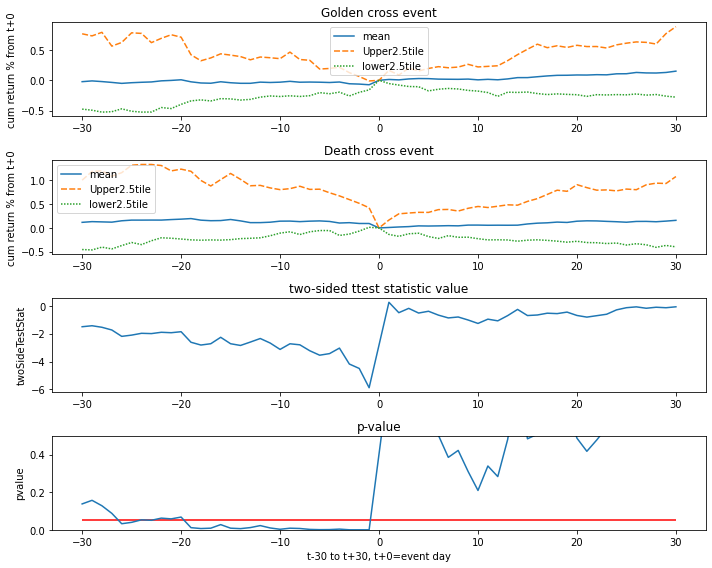

Graph: eth_SMA200d_Position, golden/death cross comparison


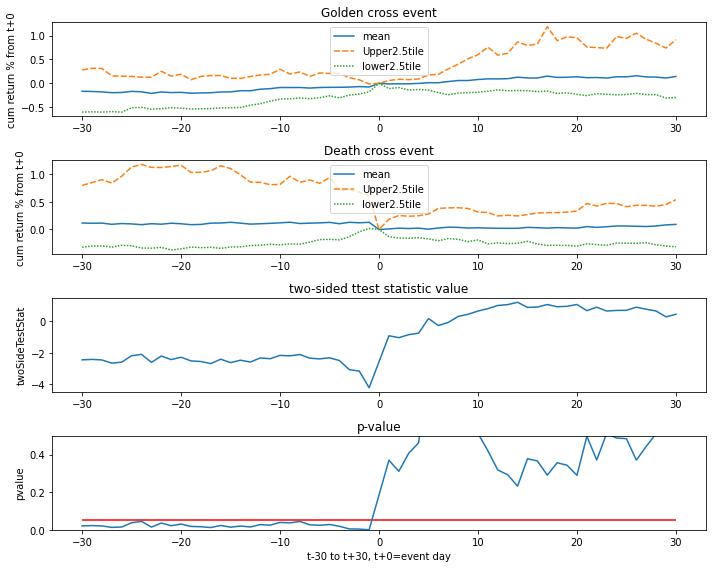

In [ ]:
twoSideSummaryForOneCrypt('eth', sma_eth_df, 30, 30)

### XRP

Unfortunately, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and after death-cross.

Graph: xrp_SMA10d_Position, golden/death cross comparison


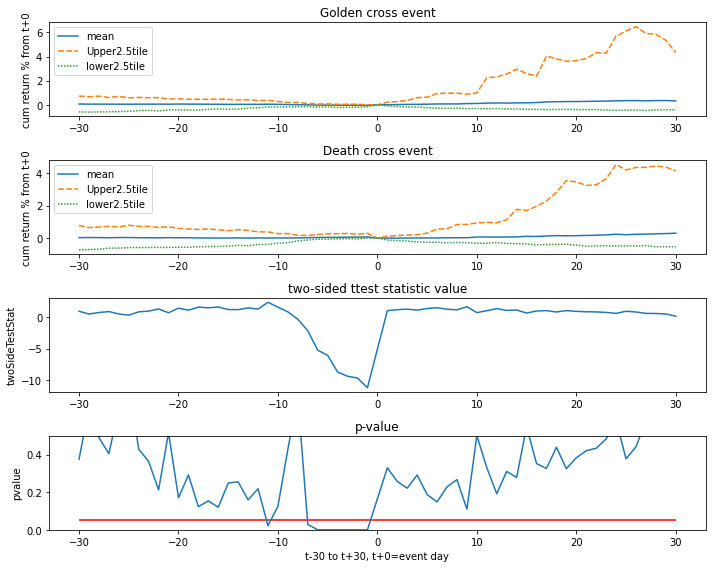

Graph: xrp_SMA50d_Position, golden/death cross comparison


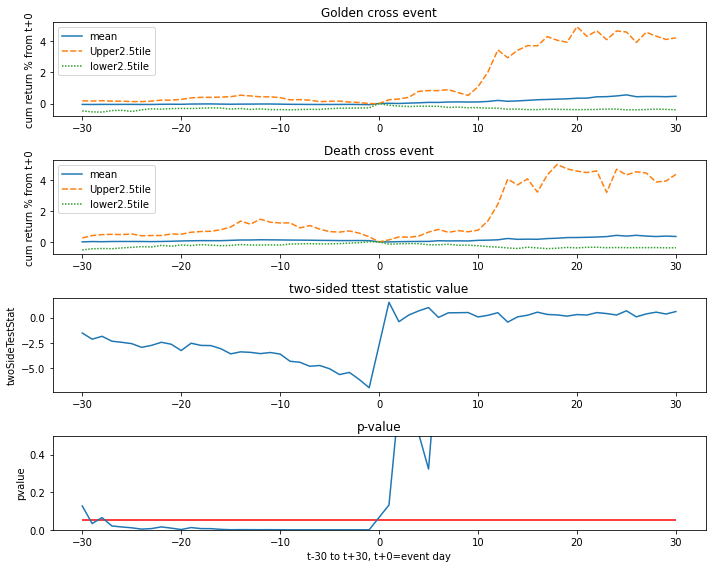

Graph: xrp_SMA100d_Position, golden/death cross comparison


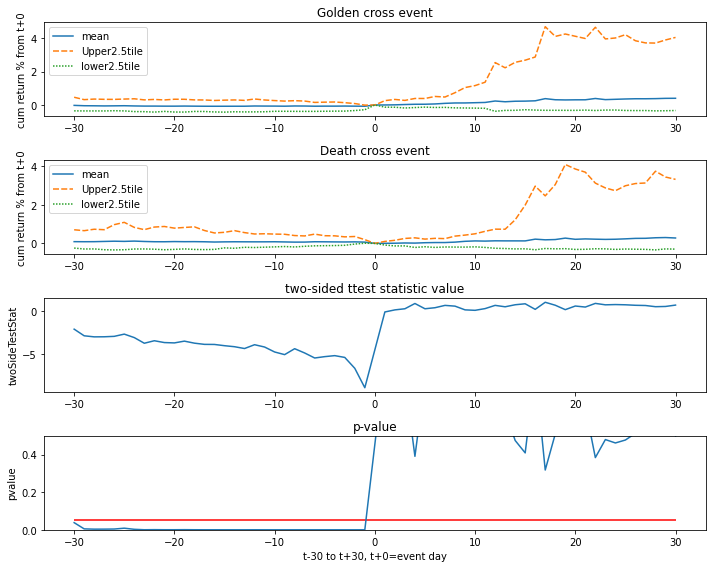

Graph: xrp_SMA200d_Position, golden/death cross comparison


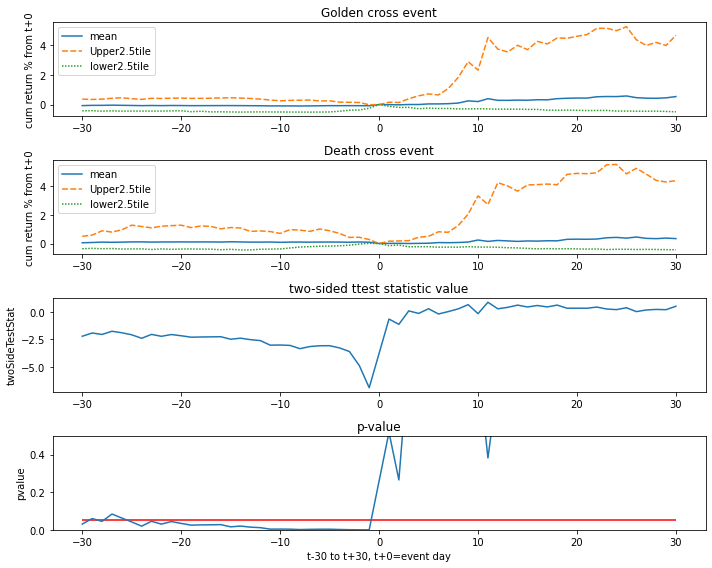

In [ ]:
twoSideSummaryForOneCrypt('xrp', sma_xrp_df, 30, 30)

### Ltc

Unfortunately, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and after death-cross.

Graph: ltc_SMA10d_Position, golden/death cross comparison


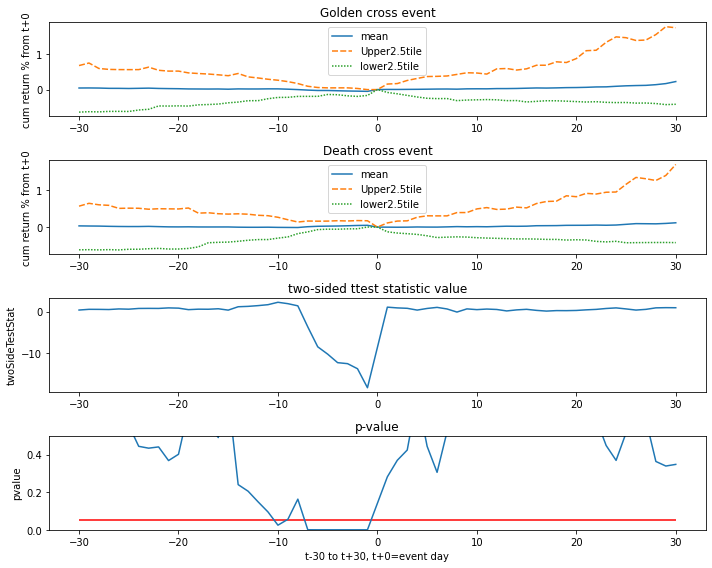

Graph: ltc_SMA50d_Position, golden/death cross comparison


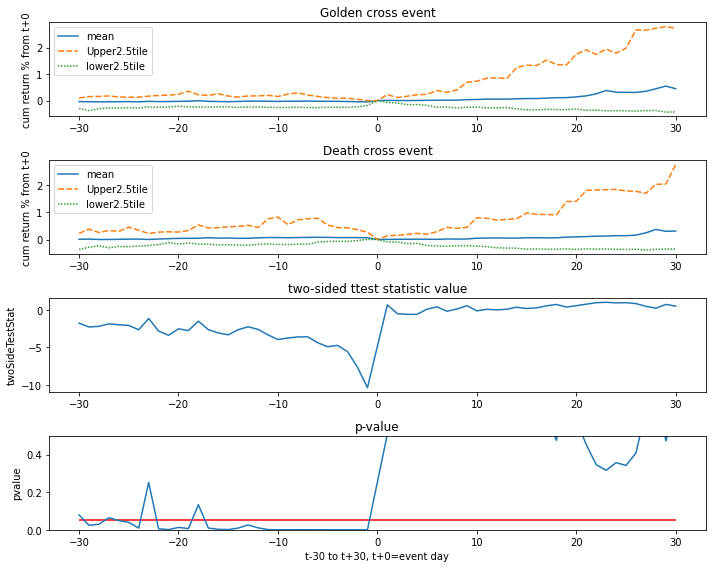

Graph: ltc_SMA100d_Position, golden/death cross comparison


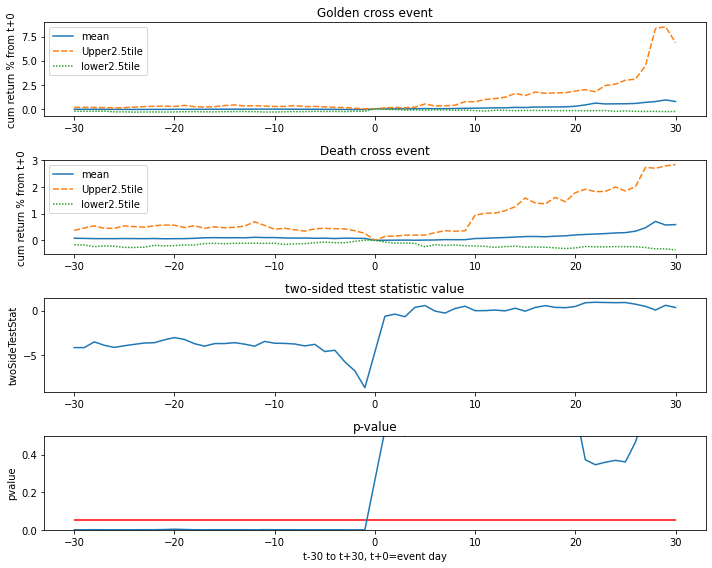

Graph: ltc_SMA200d_Position, golden/death cross comparison


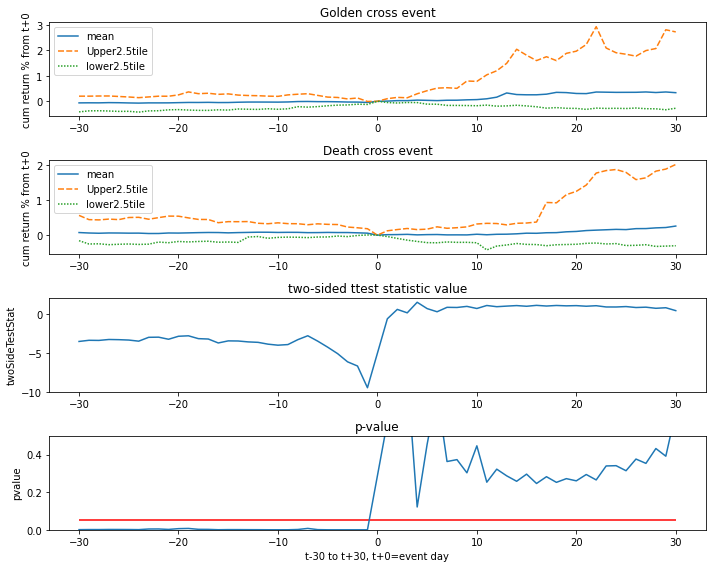

In [ ]:
twoSideSummaryForOneCrypt('ltc', sma_ltc_df, 30, 30)

### Conclusion of Event Study, SMA strategy.



*   Bitcoin: in SMA10d, t+1 and t+2 are statistically different performance between golden-cross and death cross.However, other than those, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and death-cross. In t+2, while mean cumulative return after the golden-cross was +0.70%, that after the death-cross was -0.60%. It implies that we can buy bitcoin at golden-cross while we can sell bitcoin at death-cross, such that we can make the spread of profit by +1.30% in average.
*   ETH, XRP, LTC: Unfortunately, we could not reject null hypothesis i.e. we could not declare any difference in performance between after golden-cross and after death-cross.



Based on above results, as a prescriptive solution, we can buy BTC-USD, based on 10 days SMA with golden-cross, while we can sell BTC-USD, based on 10 days SMA with death-cross, then exit position after 2 days. By continuing doing so, we may be able to accumulate profit, utilizing statistically significant return difference between BTC's 10day SMA golden-cross and death-cross.

## Event Study for RSI

Next, we implemented event study for RSI. Generally in market participants, it is said that RSI>75 (depending on situation, around 70-80) is overbought such that it's sell signal, while RSI<25 (depending on situation, around 20-30) is oversold such that it's buy signal.

Same as the case of SMA, we obtain the event day when the "overbought" "oversold" signals ignite, then apply event study to check two-sided t-test between "overbought" (=sell) signals and "oversold" (=buy) signals.

### Get RSI data

In [ ]:
#Extract only relevant data
rsi_btc_df = main_df[['day','btc_price', 'btc_price_chg', 'btc_RSI']]
rsi_eth_df = main_df[['day','eth_price', 'eth_price_chg', 'eth_RSI']]
rsi_xrp_df = main_df[['day','xrp_price', 'xrp_price_chg', 'xrp_RSI']]
rsi_ltc_df = main_df[['day','ltc_price', 'ltc_price_chg', 'ltc_RSI']]

In [ ]:
rsi_btc_df.head()

,day,btc_price,btc_price_chg,btc_RSI
0,2013-04-28,135.3000,nan,nan
1,2013-04-29,141.9600,0.0492,nan
2,2013-04-30,135.3000,-0.0469,nan
3,2013-05-01,117.0000,-0.1353,nan
4,2013-05-02,103.4300,-0.1160,nan


### Generating trading signal based on RSI

In [ ]:
def GetBuySignal(df,rsi_column):
    price_name = df.columns[1]
    signal_name = str(rsi_column) + '_OverbouthtSignal'
    df[signal_name] = 0.0
    df[signal_name] = np.where(df[rsi_column] > 75, 1.0, 0.0)
    return df

In [ ]:
def GetSellSignal(df,rsi_column):
    price_name = df.columns[1]
    signal_name = str(rsi_column) + '_OverSoldSignal'
    df[signal_name] = 0.0
    df[signal_name] = np.where(df[rsi_column] < 25, 1.0, 0.0)
    return df

In [ ]:
for df in [rsi_btc_df, rsi_eth_df, rsi_xrp_df, rsi_ltc_df]:
    GetBuySignal(df, df.columns[3])
    GetSellSignal(df, df.columns[3])

In [ ]:
rsi_btc_df

,day,btc_price,btc_price_chg,btc_RSI,btc_RSI_OverbouthtSignal,btc_RSI_OverSoldSignal
0,2013-04-28,135.3000,nan,nan,0.0000,0.0000
1,2013-04-29,141.9600,0.0492,nan,0.0000,0.0000
2,2013-04-30,135.3000,-0.0469,nan,0.0000,0.0000
3,2013-05-01,117.0000,-0.1353,nan,0.0000,0.0000
4,2013-05-02,103.4300,-0.1160,nan,0.0000,0.0000
...,...,...,...,...,...,...
2400,2020-12-27,26476.1301,0.0732,78.6687,1.0000,0.0000
2401,2020-12-28,26423.2288,-0.0020,78.2046,1.0000,0.0000
2402,2020-12-29,27125.3841,0.0266,79.8993,1.0000,0.0000
2403,2020-12-30,27424.5390,0.0110,80.5918,1.0000,0.0000


In [ ]:
def GetPosition(df, rsi_column):
    price_name = df.columns[1]
    signal_name = str(rsi_column) + '_OverbouthtSignal'
    position_name = str(rsi_column) + '_OverboughtPosi'
    df[position_name] = 0.0
    df[position_name] = df[signal_name].diff()

    signal_name = str(rsi_column) + '_OverSoldSignal'
    position_name = str(rsi_column) + '_OverSoldPosi'
    df[position_name] = 0.0
    df[position_name] = df[signal_name].diff()

    return df

In [ ]:
for df in [rsi_btc_df, rsi_eth_df, rsi_xrp_df, rsi_ltc_df]:
    GetPosition(df, df.columns[3])
    GetPosition(df, df.columns[3])

In [ ]:
rsi_btc_df.tail()

,day,btc_price,btc_price_chg,btc_RSI,btc_RSI_OverbouthtSignal,btc_RSI_OverSoldSignal,btc_RSI_OverboughtPosi,btc_RSI_OverSoldPosi
2400,2020-12-27,26476.1301,0.0732,78.6687,1.0000,0.0000,1.0000,0.0000
2401,2020-12-28,26423.2288,-0.0020,78.2046,1.0000,0.0000,0.0000,0.0000
2402,2020-12-29,27125.3841,0.0266,79.8993,1.0000,0.0000,0.0000,0.0000
2403,2020-12-30,27424.5390,0.0110,80.5918,1.0000,0.0000,0.0000,0.0000
2404,2020-12-31,28837.2885,0.0515,83.4850,1.0000,0.0000,0.0000,0.0000


### Implementing Event Study

As was in SMA case, we should compare the mean performance between after-buying signals and after-selling signals, to examine the effectiveness of RSI indicator. Therefore, we implemented two-sided t-test for RSI strategy too.

### Implementing two-sided ttest

From here, we implemented two-sided test, same as was in the case of SMA.

In [ ]:
#Implementing two-sided test
def twoSidedTestForOneRSI(currency, rsi_xxx_df,beforespan, afterspan):
  xxx_RSI_OverboughtPosi = str(currency) + '_RSI_OverboughtPosi'
  xxx_RSI_OverSoldPosi = str(currency) + '_RSI_OverSoldPosi'
  
  #listing the day indexes of when golden/death cross happened.
  obought = rsi_xxx_df[rsi_xxx_df[xxx_RSI_OverboughtPosi] == 1].index.to_list()
  osold = rsi_xxx_df[rsi_xxx_df[xxx_RSI_OverSoldPosi] == 1].index.to_list()

  obought_alldata_df, obought_ttest_df, obought_event_df = obtainAllPriceWindows(currency, obought, rsi_xxx_df, beforespan, afterspan)
  osold_alldata_df, osold_ttest_df, osold_event_df = obtainAllPriceWindows(currency, osold, rsi_xxx_df, beforespan, afterspan)

  twosidedtest_list = []
  #Based on event day of t+0, obtain t-30 - t+30 prices. 
  for t in range(len(gcross_alldata_df)):
    twosidedtest_temp = stats.ttest_ind(obought_alldata_df.iloc[t,:], osold_alldata_df.iloc[t,:])
    twosidedtest_list.append(twosidedtest_temp)
    twosidetest_results_df = pd.DataFrame.from_records(twosidedtest_list,columns=['twoSideTestStat','pvalue'])

  twosidetest_results_df.index = np.arange(-beforespan,0).tolist() + np.arange(0,afterspan+1).tolist()

  return obought_event_df, osold_event_df, twosidetest_results_df

In [ ]:
#showing summary graphs
def twoSideSummaryGraph(xxx_SMAxxxd_gcross, xxx_SMAxxxd_dcross, xxx_SMAxxxd_twoside_df, beforespan, afterspan):
  fig, axes = plt.subplots(4, 1, figsize=(10, 8))

  g0 = sns.lineplot(data=xxx_SMAxxxd_gcross, ax=axes[0])
  g0.set_title("RSI overbought event")
  g0.set_ylabel("cum return % from t+0")
  g1 = sns.lineplot(data=xxx_SMAxxxd_dcross, ax=axes[1])
  g1.set_title("RSI oversold event")
  g1.set_ylabel("cum return % from t+0")
  g2 = sns.lineplot(data=xxx_SMAxxxd_twoside_df['twoSideTestStat'], ax=axes[2])
  g2.set_title("two-sided ttest statistic value")
  g3 = sns.lineplot(data=xxx_SMAxxxd_twoside_df['pvalue'], ax=axes[3])
  g3.hlines(0.05, -beforespan, afterspan, colors='r')
  g3.set(ylim=(0, 0.5))
  g3.set_title("p-value")
  g3.set_xlabel("t-30 to t+30, t+0=event day")

  plt.tight_layout()
  plt.show()

### Bitcoin

t+1 shows p-value of 0.029, which can reject null hypothesis and imply statistically significant difference in performance between RSI overbought events and RSI oversold events. As we can see, the mean return on t+1 at overbought event is +0.91% while the mean return on t+1 at oversold event is +4.30%. It implies that we can buy bitcoin at RSI<25 while we can sell bitcoin at RSI>75, such that we can make the spread of profit by +3.39% in average. 

In [ ]:
btc_obought_event_df, btc_osold_event_df, btc_twoside_df = twoSidedTestForOneRSI('btc', rsi_btc_df, 30, 30)

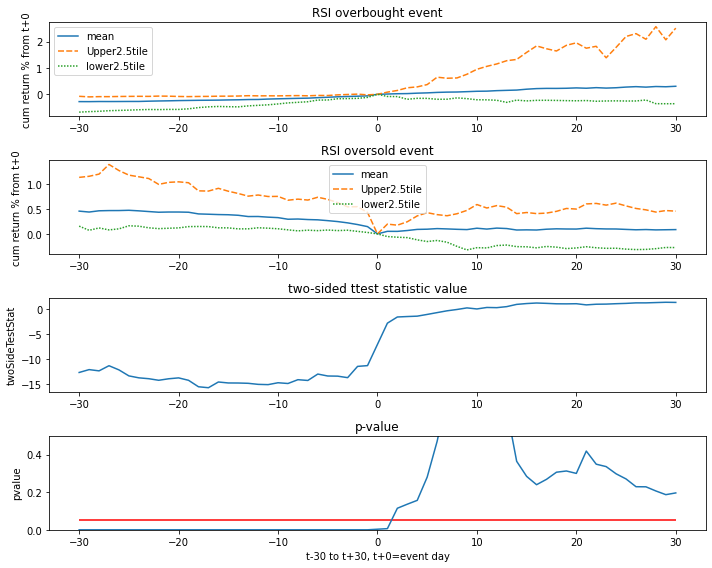

In [ ]:
twoSideSummaryGraph(btc_obought_event_df, btc_osold_event_df, btc_twoside_df, 30, 30)

In [ ]:
btc_twoside_df.iloc[30:40,:]

,twoSideTestStat,pvalue
0,nan,nan
1,-2.8276,0.0062
2,-1.5984,0.1146
3,-1.5080,0.1362
4,-1.4324,0.1566
5,-1.0883,0.2803
6,-0.7257,0.4705
7,-0.3667,0.7150
8,-0.1018,0.9192
9,0.2126,0.8322


In [ ]:
btc_obought_event_df.iloc[30:40,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0102,0.0830,-0.0829
2,0.0219,0.1458,-0.0867
3,0.0269,0.2481,-0.1885
4,0.0433,0.2816,-0.1528
5,0.0542,0.3696,-0.1551
6,0.0720,0.6505,-0.1895
7,0.0827,0.6100,-0.1865
8,0.0872,0.6213,-0.1360
9,0.1007,0.7620,-0.1649


In [ ]:
btc_osold_event_df.iloc[30:40,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0519,0.1980,-0.0537
2,0.0510,0.1762,-0.0669
3,0.0682,0.2452,-0.0754
4,0.0908,0.3641,-0.1205
5,0.0950,0.4288,-0.1540
6,0.1071,0.3895,-0.1332
7,0.1006,0.3668,-0.1679
8,0.0926,0.4075,-0.2524
9,0.0870,0.4753,-0.3240


### Eth

About ETH, unfortunately we could not reject null hypothesis in any time window between t+1 and t+30.

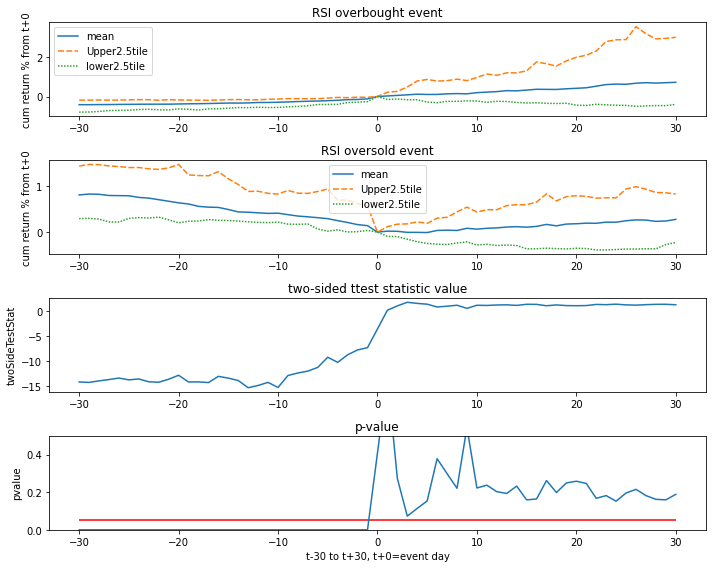

In [ ]:
eth_obought_event_df, eth_osold_event_df, eth_twoside_df = twoSidedTestForOneRSI('eth', rsi_eth_df, 30, 30)
twoSideSummaryGraph(eth_obought_event_df, eth_osold_event_df, eth_twoside_df, 30, 30)

### XRP

With regard to XRP, we can reject null hypothesis between t+4 and t+9. Especially, in t+7, we could obtain the lowest p-value with 0.0226. However, contrary with the consensus of how to use RSI, the mean cumulative return after t+7 of overbought event is +40.0%, which is significantly higher than that of oversold event i.e. +3.66%. This result indicates that we can BUY after the overbought event of RSI>75 while we can SELL after the oversold event of RSI<25, such that we can make the spread return of +36.3% in average.

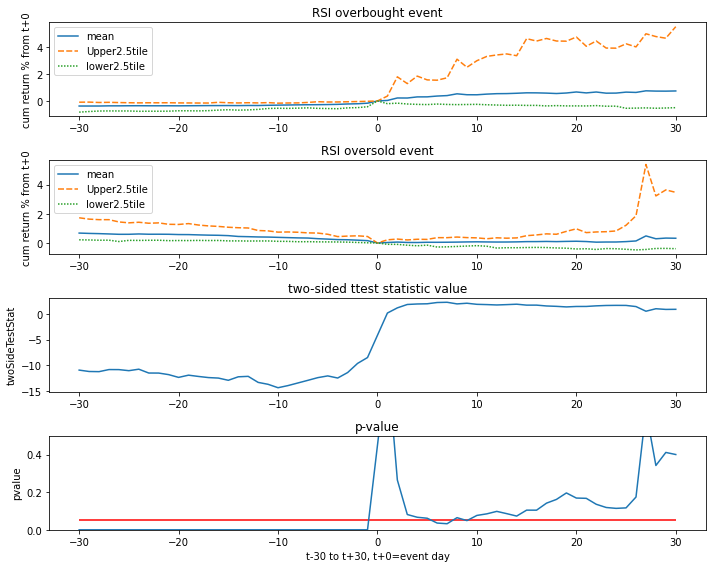

In [ ]:
xrp_obought_event_df, xrp_osold_event_df, xrp_twoside_df = twoSidedTestForOneRSI('xrp', rsi_xrp_df, 30, 30)
twoSideSummaryGraph(xrp_obought_event_df, xrp_osold_event_df, xrp_twoside_df, 30, 30)

In [ ]:
xrp_twoside_df[30:50]

,twoSideTestStat,pvalue
0,nan,nan
1,0.1283,0.8985
2,1.1288,0.2650
3,1.7832,0.0813
4,1.8793,0.0667
5,1.9170,0.0616
6,2.1626,0.0359
7,2.2093,0.0323
8,1.8950,0.0645
9,2.0236,0.0490


In [ ]:
xrp_obought_event_df.iloc[30:50,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0387,0.3636,-0.2025
2,0.2226,1.7985,-0.1653
3,0.2188,1.2943,-0.2272
4,0.3024,1.8533,-0.2548
5,0.3060,1.5701,-0.2698
6,0.3657,1.5470,-0.2304
7,0.4001,1.7255,-0.2601
8,0.5324,3.1122,-0.2729
9,0.4642,2.5120,-0.2637


In [ ]:
xrp_osold_event_df.iloc[30:50,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0339,0.2170,-0.0907
2,0.0630,0.2686,-0.0941
3,0.0357,0.2086,-0.1513
4,0.0330,0.2550,-0.1902
5,0.0489,0.2452,-0.1487
6,0.0473,0.3649,-0.2767
7,0.0518,0.3640,-0.2629
8,0.0605,0.4065,-0.2370
9,0.0730,0.3680,-0.2095


### Ltc

In ltc, we can see the p-value < 0.05 on t+25 and t+26. Especially, we could obtain the lowest p-value of 0.037 in t+26. However, contrary with the consensus of how to use RSI, the mean cumulative return after t+26 of overbought event is +44.0%, which is significantly higher than that of oversold event i.e. -5.30%. This result indicates that we can BUY after the overbought event of RSI>75 while we can SELL after the oversold event of RSI<25, such that we can make the spread return of +49.3% in average.

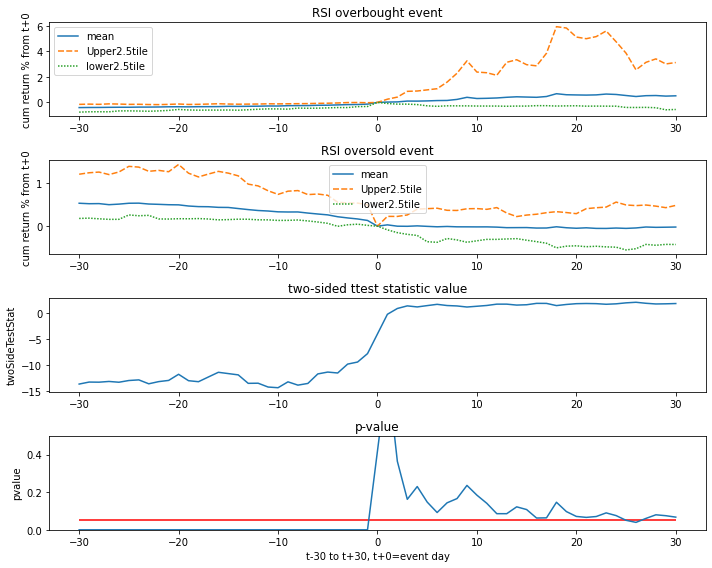

In [ ]:
ltc_obought_event_df, ltc_osold_event_df, ltc_twoside_df = twoSidedTestForOneRSI('ltc', rsi_ltc_df, 30, 30)
twoSideSummaryGraph(ltc_obought_event_df, ltc_osold_event_df, ltc_twoside_df, 30, 30)

In [ ]:
ltc_twoside_df[30:]

,twoSideTestStat,pvalue
0,nan,nan
1,-0.2054,0.8381
2,0.9157,0.3643
3,1.4191,0.1622
4,1.2153,0.2301
5,1.4714,0.1476
6,1.7192,0.0919
7,1.4868,0.1435
8,1.4058,0.1661
9,1.1995,0.2361


In [ ]:
ltc_obought_event_df.iloc[30:,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0254,0.2513,-0.0855
2,0.0391,0.4160,-0.1355
3,0.1041,0.8671,-0.1356
4,0.1007,0.8938,-0.1710
5,0.1174,0.9827,-0.2679
6,0.1438,1.0741,-0.3080
7,0.1527,1.5907,-0.2693
8,0.2346,2.2871,-0.2713
9,0.3991,3.2585,-0.2739


In [ ]:
ltc_osold_event_df.iloc[30:,:]

,mean,Upper2.5tile,lower2.5tile
0,0.0000,0.0000,0.0000
1,0.0310,0.2299,-0.0860
2,-0.0003,0.2282,-0.1517
3,-0.0029,0.2628,-0.1914
4,0.0072,0.4001,-0.2173
5,-0.0043,0.4105,-0.3646
6,-0.0144,0.4209,-0.3779
7,-0.0067,0.3718,-0.2888
8,-0.0152,0.3682,-0.3218
9,-0.0157,0.4082,-0.3770


### Conclusion of EVent Study, RSI strategy.

*  Bitcoin: t+1 shows p-value of 0.029, which can reject null hypothesis and imply statistically significant difference in performance between RSI overbought events and RSI oversold events. As we can see, the mean return on t+1 at overbought event is +0.91% while the mean return on t+1 at oversold event is +4.30%. It implies that we can buy bitcoin at RSI<25 while we can sell bitcoin at RSI>75, such that we can make the spread of profit by +3.39% in average.

*  Eth: We could not reject null hypothesis in all t+1 - t+30 time windows.

*  Xrp: We could reject null hypothesis between t+4 and t+9. Especially, in t+7, we could obtain the lowest p-value with 0.0226. However, contrary with the consensus of how to use RSI, the mean cumulative return after t+7 of overbought event is +40.0%, which is significantly higher than that of oversold event i.e. +3.66%. This result indicates that we can BUY after the overbought event of RSI>75 while we can SELL after the oversold event of RSI<25, such that we can make the spread return of +36.3% in average.

*  Ltc: We could see the p-value < 0.05 on t+25 and t+26. Especially, we could obtain the lowest p-value of 0.037 in t+26. However, contrary with the consensus of how to use RSI, the mean cumulative return after t+26 of overbought event is +44.0%, which is significantly higher than that of oversold event i.e. -5.30%. This result indicates that we can BUY after the overbought event of RSI>75 while we can SELL after the oversold event of RSI<25, such that we can make the spread return of +49.3% in average.

## Overall conclusion

As we can see in the conclusion at both SMA and RSI strategies, at some trading windows periods for some cryptocurrencies, there exists the buy/sell trading strategy which shows statistically significantly different performance between buy signals and sell signals.

Of course, we do not assure the future return from past success. Also, the investment/trading should be done by self-responsibility. We cannot officially recommend buy or sell recommendation due to compliance matter (Note: In financial industry, we should be very careful about recommending buy or sell to clients and public).

However, as results of Event Study and two-sided t-test, we could formulate the prescriptive solutions about when to buy/sell cryptocurrencies, utilizing SMA and RSI technical indicators. While we never assure your monetary success by following those strategies, our findings this time look interesting as the learning purpose. 